In [1]:
# Run the rof_pdhg_implementation_2d.py script
%run rof_pdhg_implementation_2d.py

torch.Size([786432, 1])


TypeError: unsupported operand type(s) for -: 'tuple' and 'Tensor'

In [2]:
# Import necessary modules
import matplotlib.pyplot as plt
from skimage import data
from skimage.transform import resize
import torch
from operators import Finite_Difference_Gradient_2D
from hj_prox import HJ_prox

# Set device
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

# Load and preprocess the image
pixels = 512
torch.manual_seed(13)
astronaut_image = data.astronaut()
#astronaut_image = resize(astronaut_image, (pixels, pixels), anti_aliasing=True)  # Resize to 50x50
astronaut_image = astronaut_image.astype('float32') / 255.0
astronaut_tensor = torch.from_numpy(astronaut_image).unsqueeze(0).permute(0, 3, 1, 2)
noise_level = 1e-1
data_tensor = astronaut_tensor + noise_level * torch.randn_like(astronaut_tensor, device='cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_tensor = data_tensor.to(device)


# Define input tensor
x = data_tensor.reshape(-1, 1)
t = 0.0001
int_samples = 1000
RGB_dim = 3

# Define the p-norm function
def p_norm(x, p=2):
    """
    Computes the p-norm of a given tensor along a specified dimension.
    Args:
        x (torch.Tensor): The input tensor.
        p (int, optional): The order of the norm. Default is 2 (Euclidean norm).
    Returns:
        torch.Tensor: The p-norm of the input tensor.
    """
    return torch.norm(x, p=p, dim=1)

# Compute the proximal of the TV norm
prox_tv = HJ_prox(x, t=t, delta=1e-1, int_samples=int_samples, device=device)

# Compute the proximal of the p-norm (e.g., p=2)
p=5
prox_p_norm = HJ_prox(x, f=lambda x: p_norm(x, p=p), t=t, delta=1e-1, int_samples=int_samples, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


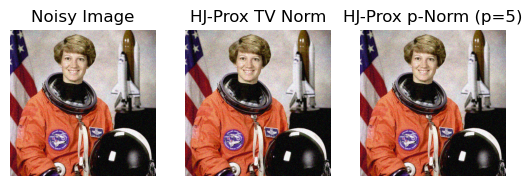

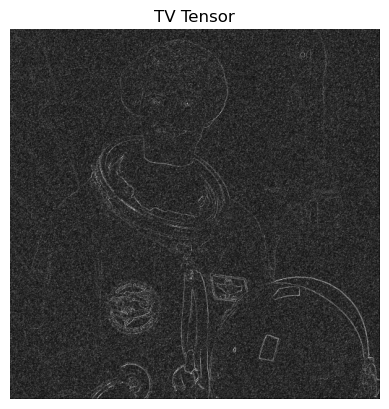

In [3]:
# Visualize the original noisy image and the proximals
plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(data_tensor[0].permute(1, 2, 0).cpu().numpy())
plt.axis("off")
plt.title("Noisy Image")

plt.subplot(1, 3, 2)
plt.imshow(prox_tv.reshape(data_tensor.shape)[0].permute(1, 2, 0).cpu().numpy())
plt.axis("off")
plt.title("HJ-Prox TV Norm")

plt.subplot(1, 3, 3)
plt.imshow(prox_p_norm.reshape(data_tensor.shape)[0].permute(1, 2, 0).cpu().numpy())
plt.axis("off")
plt.title(f"HJ-Prox p-Norm (p={p})")

plt.show()

def compute_tv_tensor(image_tensor):
    """
    Computes the TV tensor of the input image tensor.

    Args:
        image_tensor (torch.Tensor): Input image tensor of shape (1, 3, H, W).

    Returns:
        torch.Tensor: TV tensor of the input image.
    """
    # Initialize the Finite Difference Gradient operator
    G = Finite_Difference_Gradient_2D()

    # Compute the Finite Difference Gradient of the image tensor
    tv_tensor = G(image_tensor)

    # Compute the TV difference to get the correct shape (1, 3, H, W)
    tv_diff = torch.norm(tv_tensor, p=1, dim=1, keepdim=True)

    return tv_diff

# Compute the TV tensor of the noisy image
tv_tensor = compute_tv_tensor(data_tensor)

# Plot the TV tensor of the image
plt.figure()
plt.imshow(tv_tensor[0].permute(1, 2, 0).squeeze().cpu().numpy(), cmap='gray')
plt.axis("off")
plt.title("TV Tensor")
plt.show()
